Empty DataFrame
Columns: [xrp_volume, theta_volume, xrp_close, theta_close]
Index: []
xrp_volume      float64
theta_volume    float64
xrp_close       float64
theta_close     float64
dtype: object
                      xrp_volume  theta_volume  xrp_close  theta_close
time                                                                  
2023-05-30 16:30:00  107004259.2      789975.6       0.52         0.87
2023-05-30 17:30:00   63777449.9      482664.7       0.52         0.87
2023-05-30 18:30:00  353628002.4      862576.5       0.52         0.87
2023-05-30 19:30:00   88802622.4      431916.1       0.52         0.87
2023-05-30 20:30:00   61217870.5      721893.4       0.52         0.87
Index(['xrp_volume', 'theta_volume', 'xrp_close', 'theta_close'], dtype='object')
*****
Total Return: -19.48%
Annualized Return: -2.71%
Annualized Volatility: 20.11%
Sharpe Ratio: -0.13


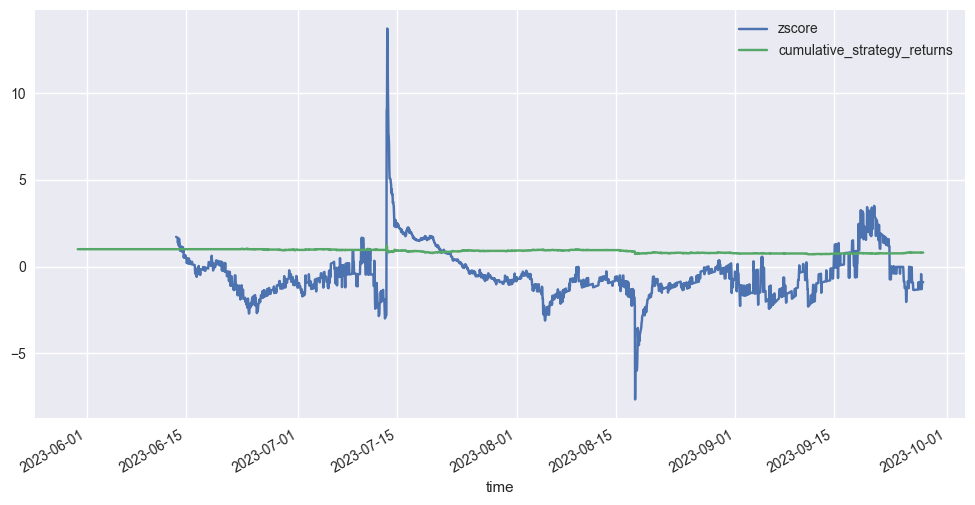

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
sys.path.append('/Users/markwindsor/Desktop/atlas_trade')
from src.utils.technical_indicators import *
import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")


class StatArbCryptoBacktest:
    def __init__(self, data, symbol_one, symbol_two, transaction_cost):
        self.data = data
        self.symbol_one = symbol_one
        self.symbol_two = symbol_two
        self.tc = transaction_cost
        self.results = None

    @staticmethod
    def compute_hedge_ratio(y, x):
        y, x = y.dropna(), x.dropna()

        # Check if data is sufficient
        if len(y) < 50 or len(x) < 50:
            return np.nan

        x = sm.add_constant(x)
        model = sm.OLS(y, x).fit()
        return model.params[1]
    
    def compute_hedge_ratio(self, y, x):
        # 1. Merge the two series on datetime index
        df = pd.DataFrame({
            'x': x,
            'y': y
        })

        # 2. Drop rows with NaN values to ensure alignment
        df.dropna(inplace=True)

        # 3. Extract the aligned series
        x_aligned = df['x'].values.reshape(-1, 1)
        y_aligned = df['y'].values

        model = LinearRegression().fit(x_aligned, y_aligned)
        return model.coef_[0]

    def set_signals(self):
        try:
            df = self.data.copy()

            hedge_ratio = self.compute_hedge_ratio(
                df[self.symbol_two], df[self.symbol_one])

            # Compute other metrics based on hedge ratio
            df['spread'] = df[self.symbol_one] - hedge_ratio * df[self.symbol_two]
            df['mean_spread'] = df['spread'].rolling(window=336).mean()
            df['std_spread'] = df['spread'].rolling(window=336).std()
            df['zscore'] = (df['spread'] - df['mean_spread']) / df['std_spread']

            # Initialize trading_signal column with zeros
            df['trading_signal'] = 0

            # Set trading signals based on zscore
            # Long when zscore is below -1.8
            df.loc[df['zscore'] < -1.8, 'trading_signal'] = 1

            # Neutral when zscore crosses 0
            df.loc[(df['zscore'] > 0) & (df['zscore'].shift(1) <= 0), 'trading_signal'] = 0

            # Short when zscore is above 1.8
            df.loc[df['zscore'] > 1.8, 'trading_signal'] = -1

            # Neutral when zscore crosses 0
            df.loc[(df['zscore'] < 0) & (df['zscore'].shift(1) >= 0), 'trading_signal'] = 0

            # Carry forward the trading signal
            df['trading_signal'] = df['trading_signal'].replace(to_replace=0, method='ffill')

            print('*****')
            
            self.results = df.copy()

            self.results.to_csv('two.csv', index=True)
    
        except Exception as e:
            print(f"Error in set_signals_modified: {e}")

    def backtest(self):
        if self.results is None:
            self.set_signals()  
        
        # Ensure 'trading_signal' exists in self.results
        if 'trading_signal' not in self.results.columns:
            raise ValueError("set_signals did not compute properly or did not produce the trading_signal column!")
        
        # Strategy Returns without transaction cost
        self.results['strategy_returns'] = self.results['trading_signal'].shift(1) * self.results[self.symbol_one].pct_change()
        self.results['strategy_returns'] -= self.tc * abs(self.results['trading_signal'].diff())
        
        # Cumulative Returns
        self.results['cumulative_market_returns'] = (1 + self.results[self.symbol_one].pct_change()).cumprod()
        self.results['cumulative_strategy_returns'] = (1 + self.results['strategy_returns']).cumprod()
        
        # Set initial capital to 1 for both market and strategy cumulative returns
        self.results['cumulative_market_returns'].iloc[0] = 1
        self.results['cumulative_strategy_returns'].iloc[0] = 1


    def analyze_performance(self):
        # Assuming you want some basic performance metrics
        total_return = self.results['cumulative_strategy_returns'].iloc[-1] - 1
        annualized_return = ((1 + total_return)**(365 / len(self.results))) - 1
        annualized_vol = self.results['strategy_returns'].std() * (365**0.5)
        sharpe_ratio = annualized_return / annualized_vol

        print(f"Total Return: {total_return:.2%}")
        print(f"Annualized Return: {annualized_return:.2%}")
        print(f"Annualized Volatility: {annualized_vol:.2%}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

        self.results.to_csv('two.csv', index=True)

        # Plot cumulative returns
        self.results[['zscore', 'cumulative_strategy_returns']].plot(figsize=(12, 6))



data_path = '/Users/markwindsor/Desktop/atlas_trade/src/strategies/statistical_arbitrage_crypto/backtest_data_1h.csv'
data = pd.read_csv(data_path)
data['time'] = pd.to_datetime(data['time'], errors='coerce')

data.set_index('time', inplace=True)
data = data.dropna(subset=['xrp_close', 'theta_close'])
non_numeric_theta = data[pd.to_numeric(data['theta_close'], errors='coerce').isna()]
data = data[data['theta_close'] != 'theta_close']
data['xrp_close'] = data['xrp_close'].astype(float)
data['theta_close'] = data['theta_close'].astype(float)

print(non_numeric_theta)
print(data.dtypes)
print(data.head())
print(data.columns)

# Check the columns exist in the DataFrame to rule out issues related to them
tester = StatArbCryptoBacktest(data, 'xrp_close', 'theta_close', 0.0005)
tester.set_signals()
tester.backtest()
tester.analyze_performance()
